In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [17]:
# Imports
import torch
import torchvision
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
%matplotlib inline
import torchvision.transforms as transforms
from torch.utils.data import random_split
import torch.nn.functional as F
import torch.nn as nn

# Load the data 

In [2]:
# # Download training dataset
# dataset = MNIST(root='/content/gdrive/MyDrive/pytorch learning and project/pytorch-logistic-regression-images/data/', download=True)
# dataset 

In [3]:
# Download training dataset
dataset = MNIST(root='data/', download=True)
dataset 

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Dataset MNIST
    Number of datapoints: 60000
    Root location: data/
    Split: Train

In [ ]:
# test_dataset = MNIST(root='/content/gdrive/MyDrive/pytorch learning and project/pytorch-logistic-regression-images/data/', train=False)
# len(test_dataset)

In [4]:
test_dataset = MNIST(root='data/', train=False)
len(test_dataset)

10000

Label: 0


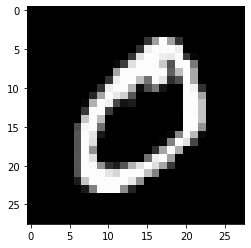

In [10]:
image, label = dataset[1]
plt.imshow(image, cmap='gray')
print('Label:', label)

Label: 3


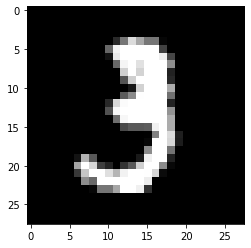

In [9]:
image, label = dataset[10]
plt.imshow(image, cmap='gray')
print('Label:', label)

In [11]:
dataset = MNIST(root='data/', 
                train=True,
                transform=transforms.ToTensor())

In [12]:
img_tensor, label = dataset[0]
print(img_tensor.shape, label)

torch.Size([1, 28, 28]) 5


# Training and validation data

In [38]:
train_ds, val_ds = random_split(dataset, [50000, 10000])
len(train_ds), len(val_ds)

(50000, 10000)

In [39]:
# data loader
from torch.utils.data import DataLoader
batch_size = 128
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

# LR Model

In [40]:
input_size = 28*28
num_classes = 10

class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = MnistModel()

In [41]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [42]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    optimizer = opt_func(model.parameters(), lr)
    history = [] # for recording epoch-wise results
    
    for epoch in range(epochs):
        
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)

    return history

In [43]:
result0 = evaluate(model, val_loader)
result0

{'val_acc': 0.0644778460264206, 'val_loss': 2.3432729244232178}

In [44]:
history = fit(30, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.9713, val_acc: 0.6224
Epoch [1], val_loss: 1.6958, val_acc: 0.7382
Epoch [2], val_loss: 1.4897, val_acc: 0.7746
Epoch [3], val_loss: 1.3341, val_acc: 0.7923
Epoch [4], val_loss: 1.2144, val_acc: 0.8048
Epoch [5], val_loss: 1.1206, val_acc: 0.8129
Epoch [6], val_loss: 1.0455, val_acc: 0.8214
Epoch [7], val_loss: 0.9841, val_acc: 0.8266
Epoch [8], val_loss: 0.9331, val_acc: 0.8323
Epoch [9], val_loss: 0.8901, val_acc: 0.8350
Epoch [10], val_loss: 0.8533, val_acc: 0.8388
Epoch [11], val_loss: 0.8215, val_acc: 0.8430
Epoch [12], val_loss: 0.7937, val_acc: 0.8447
Epoch [13], val_loss: 0.7691, val_acc: 0.8472
Epoch [14], val_loss: 0.7473, val_acc: 0.8490
Epoch [15], val_loss: 0.7278, val_acc: 0.8513
Epoch [16], val_loss: 0.7102, val_acc: 0.8533
Epoch [17], val_loss: 0.6942, val_acc: 0.8536
Epoch [18], val_loss: 0.6796, val_acc: 0.8545
Epoch [19], val_loss: 0.6663, val_acc: 0.8557
Epoch [20], val_loss: 0.6541, val_acc: 0.8578
Epoch [21], val_loss: 0.6428, val_acc: 0.859

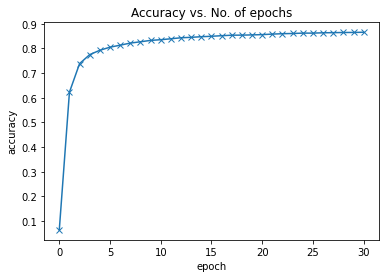

In [45]:
history1 = [result0] + history
accuracies = [result['val_acc'] for result in history1]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

Testing the model

In [47]:
# Define test dataset
test_dataset = MNIST(root='data/', 
                     train=False,
                     transform=transforms.ToTensor())

In [51]:
test_loader = DataLoader(test_dataset, batch_size=256)
result = evaluate(model, test_loader)
result

{'val_acc': 0.8709961175918579, 'val_loss': 0.5508143901824951}

Label: 7 , Predicted: 7


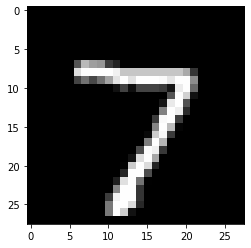

In [52]:
# prediction on individual image
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()
  
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 9 , Predicted: 4


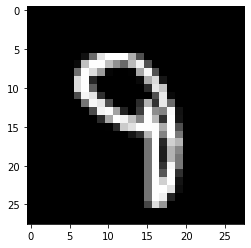

In [53]:
img, label = test_dataset[193]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

In [57]:
torch.save(model.state_dict(), '/content/drive/MyDrive/pytorch learning and project/pytorch-logistic-regression-images/mnist-logistic.pth')